ID: Station identification code uniquely identifying each weather station 

DATE: Date of the record in YYYY-MM-DD format.

MAX: Maximum temperature measured in tenths of degrees Celsius.

TMIN: Minimum temperature measured in tenths of degrees Celsius.

EVAP: Evaporation of water from an evaporation pan measured in tenths of millimeters.

PRCP: Precipitation measured in tenths of millimeters.

Latitude: Latitude coordinates of the weather station in decimal degrees.

Longitude: Longitude coordinates of the weather station in decimal degrees.

Elevation: Elevation of the weather station measured in meters. Missing values are denoted as -999.9.

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import geodatasets

In [31]:
# Load the data
dataset = pd.read_csv("data/weather_data/weather.csv")

# cleaning nan
dataset.dropna(subset=['TMAX','TMIN','PRCP'], how='all')

# select corn belt
data = dataset[
    (dataset['Latitude'] >= 36.5) & (dataset['Latitude'] <= 45.0) &
    (dataset['Longitude'] >= -97.0) & (dataset['Longitude'] <= -84.0)
]

print(data.size)

75297552


In [32]:

# Convert 'DATE' to datetime format
data['DATE'] = pd.to_datetime(data['DATE'], format='%m/%d/%Y', errors='coerce')

# Extract year and month after conversion
data['YEAR'] = data['DATE'].dt.year
data['MONTH'] = data['DATE'].dt.month

# Display the first 10 rows
data.head(10)

data['TMAX']=data['TMAX']/10
data['TMIN']=data['TMIN']/10

max TMAX: 53.9
min TMAX: -45.6


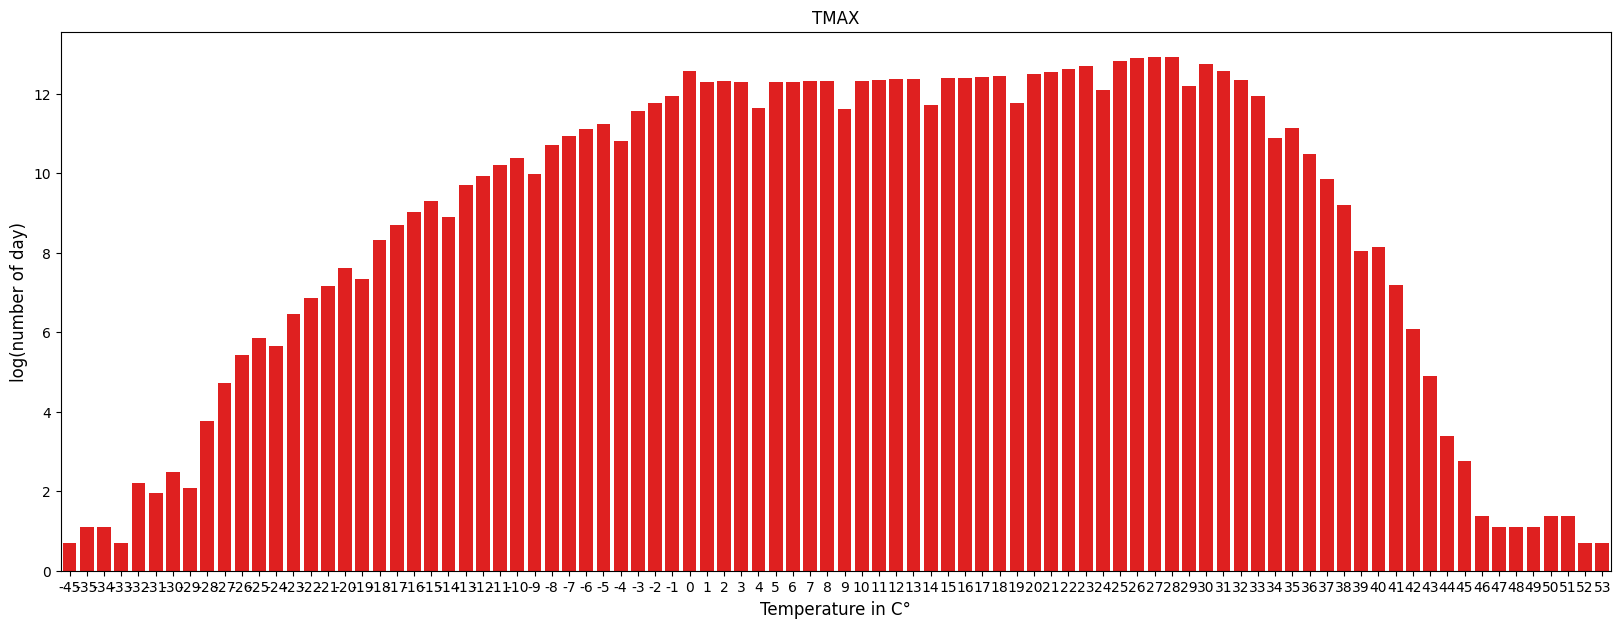

In [33]:
#exploratory data analysis TMAX
d_aggregate_tmax = data[['TMAX','DATE']].copy()
print("max TMAX: "+str(d_aggregate_tmax['TMAX'].max()))
print("min TMAX: "+str(d_aggregate_tmax['TMAX'].min()))
d_aggregate_tmax['TMAX']=(d_aggregate_tmax['TMAX']).astype(int)
d_aggregate_tmax = d_aggregate_tmax.groupby(['TMAX']).count().reset_index()
d_aggregate_tmax['DATE'] = np.log(d_aggregate_tmax['DATE']+1)
plt.figure(figsize=(20, 7))
sns.barplot(data=d_aggregate_tmax,x='TMAX',y="DATE",color="red")
plt.title("TMAX")
plt.xlabel("Temperature in C°", fontsize=12)
plt.ylabel("log(number of day)", fontsize=12)
plt.show()

max TMIN: 42.2
min TMIN: -72.8


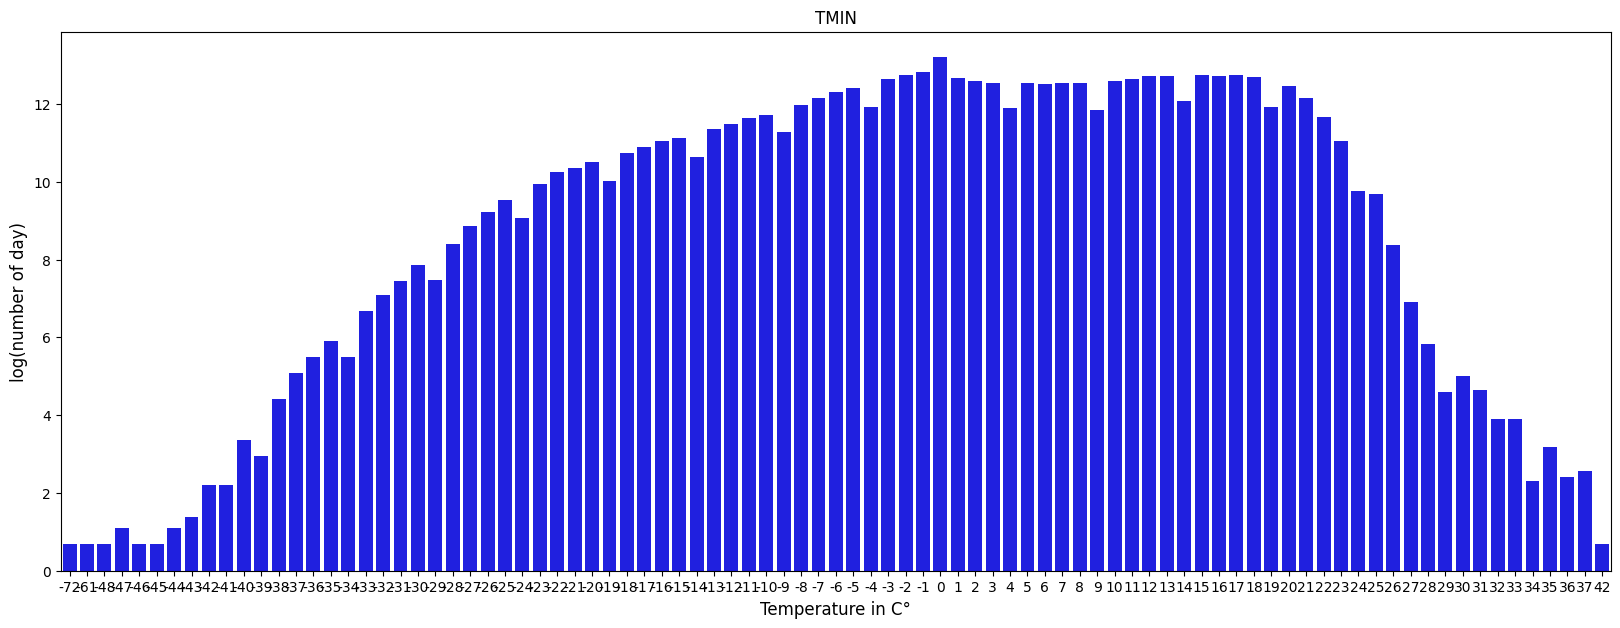

In [34]:
#exploratory data analysis TMIN
d_aggregate_tmin = data[['TMIN','DATE']].copy()
print("max TMIN: "+str(d_aggregate_tmin['TMIN'].max()))
print("min TMIN: "+str(d_aggregate_tmin['TMIN'].min()))
d_aggregate_tmin['TMIN']=(d_aggregate_tmin['TMIN']).astype(int)
d_aggregate_tmin = d_aggregate_tmin.groupby(['TMIN']).count().reset_index()
d_aggregate_tmin['DATE'] = np.log(d_aggregate_tmin['DATE']+1)
plt.figure(figsize=(20, 7))
sns.barplot(data=d_aggregate_tmin,x='TMIN',y="DATE",color="blue")
plt.xlabel("Temperature in C°", fontsize=12)
plt.ylabel("log(number of day)", fontsize=12)
plt.title("TMIN")
plt.show()

max PRCP: 4826.0
min PRCP: 0.0


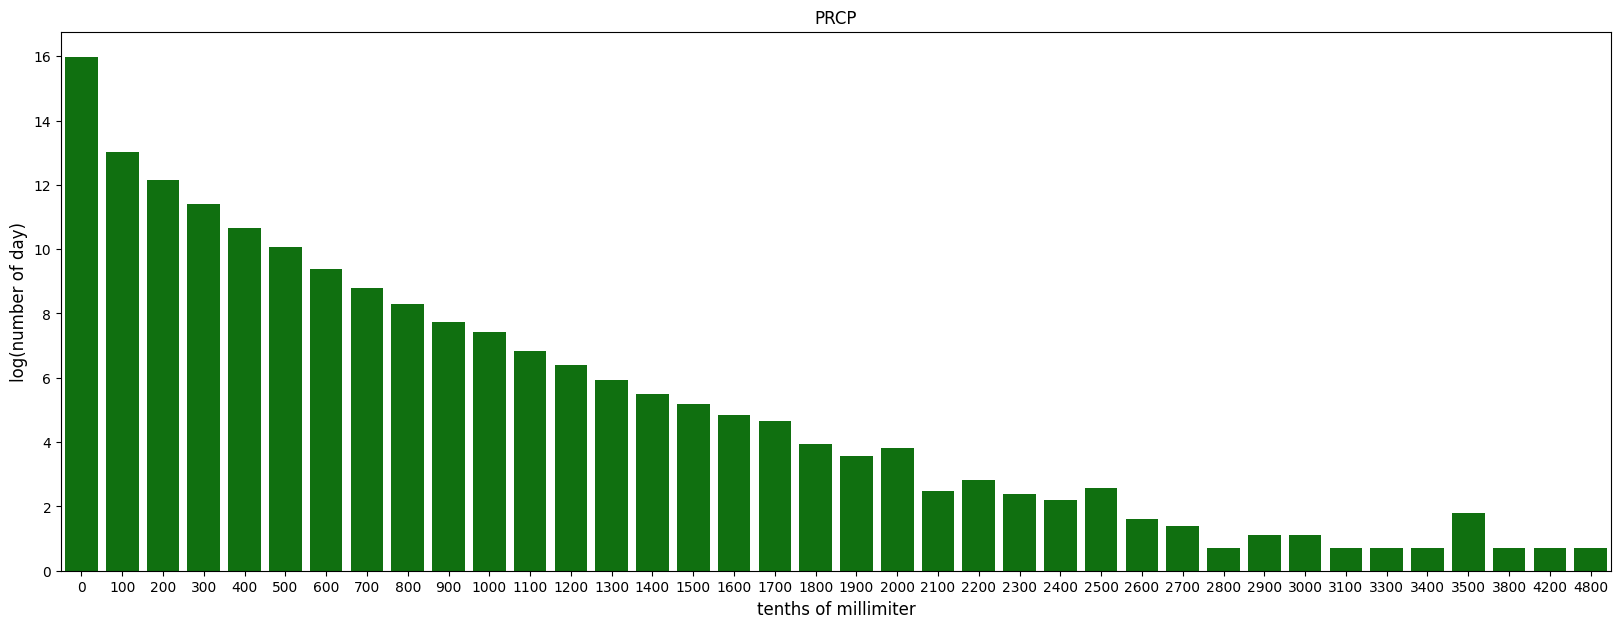

In [35]:
#exploratory data analysis TMIN
d_aggregate_prcp = data[['PRCP','DATE']].copy()
print("max PRCP: "+str(d_aggregate_prcp['PRCP'].max()))
print("min PRCP: "+str(d_aggregate_prcp['PRCP'].min()))
d_aggregate_prcp['PRCP']=(d_aggregate_prcp['PRCP']/100).astype(int)*100
d_aggregate_prcp = d_aggregate_prcp.groupby(['PRCP']).count().reset_index()
d_aggregate_prcp['DATE'] = np.log(d_aggregate_prcp['DATE']+1)
plt.figure(figsize=(20, 7))
sns.barplot(data=d_aggregate_prcp,x='PRCP',y="DATE",color="green")
plt.xlabel("tenths of millimiter", fontsize=12)
plt.ylabel("log(number of day)", fontsize=12)
plt.title("PRCP")
plt.show()

In [36]:
# clean corrupted value
data_clean = data[(data['TMAX'] < 50) & (data['TMAX'] > -45) & 
                  (data['TMIN'] > -45) & (data['TMIN'] < 50) & (data['PRCP'] < 3400)].copy()

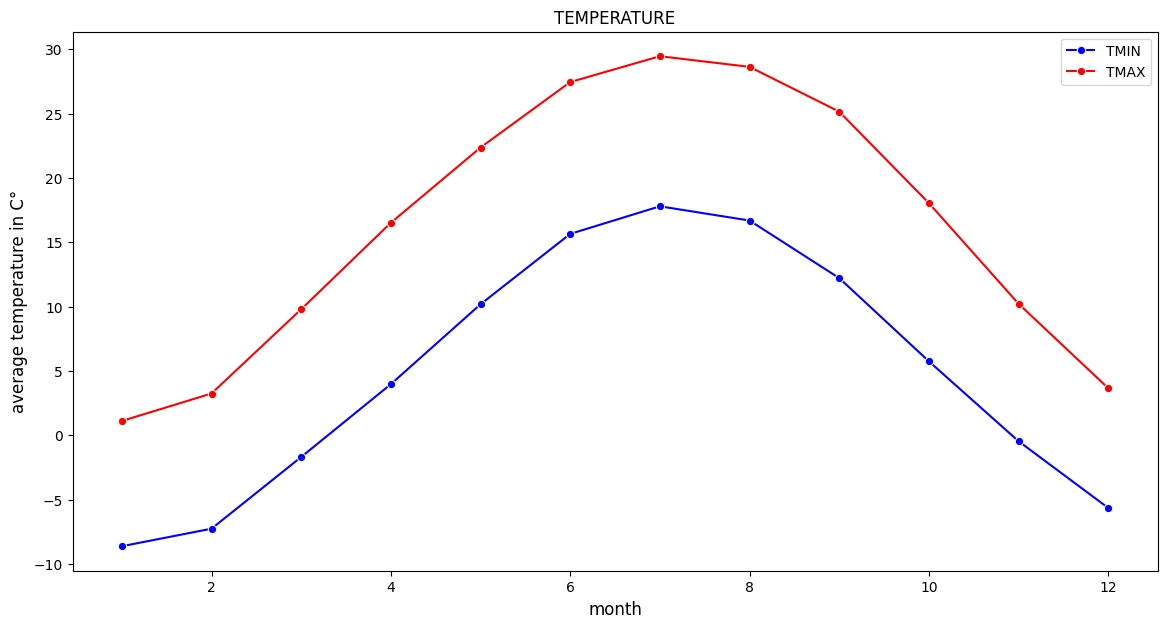

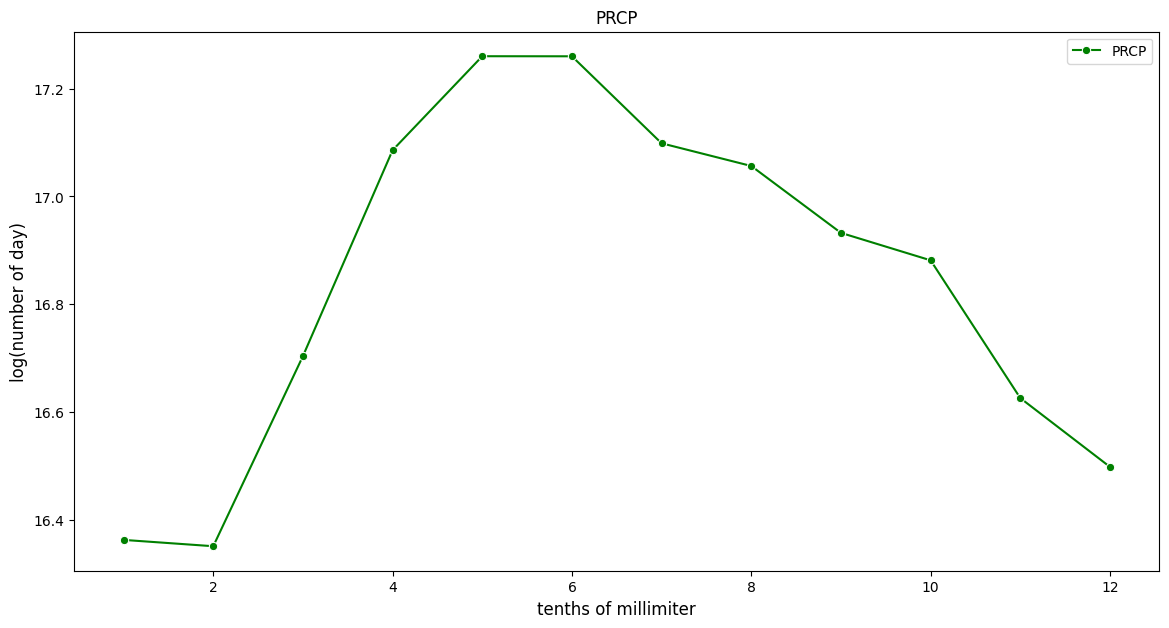

In [37]:
#plot of seasonal trend
d_aggregate_month = data_clean[['MONTH', 'TMIN', 'TMAX']].groupby('MONTH').mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(data=d_aggregate_month, x="MONTH", y="TMIN", marker="o", label="TMIN", color="blue")
sns.lineplot(data=d_aggregate_month, x="MONTH", y="TMAX", marker="o", label="TMAX", color="red")
plt.xlabel("month", fontsize=12)
plt.ylabel("average temperature in C°", fontsize=12)
plt.title("TEMPERATURE")
plt.show()

d_aggregate_month = data_clean[['MONTH', 'PRCP']].groupby('MONTH').sum().reset_index()
d_aggregate_month['PRCP'] = np.log(d_aggregate_month['PRCP'])
plt.figure(figsize=(14, 7))
sns.lineplot(data=d_aggregate_month, x="MONTH", y="PRCP", marker="o", label="PRCP", color="green")
plt.xlabel("tenths of millimiter", fontsize=12)
plt.ylabel("log(number of day)", fontsize=12)
plt.title("PRCP")
plt.show()

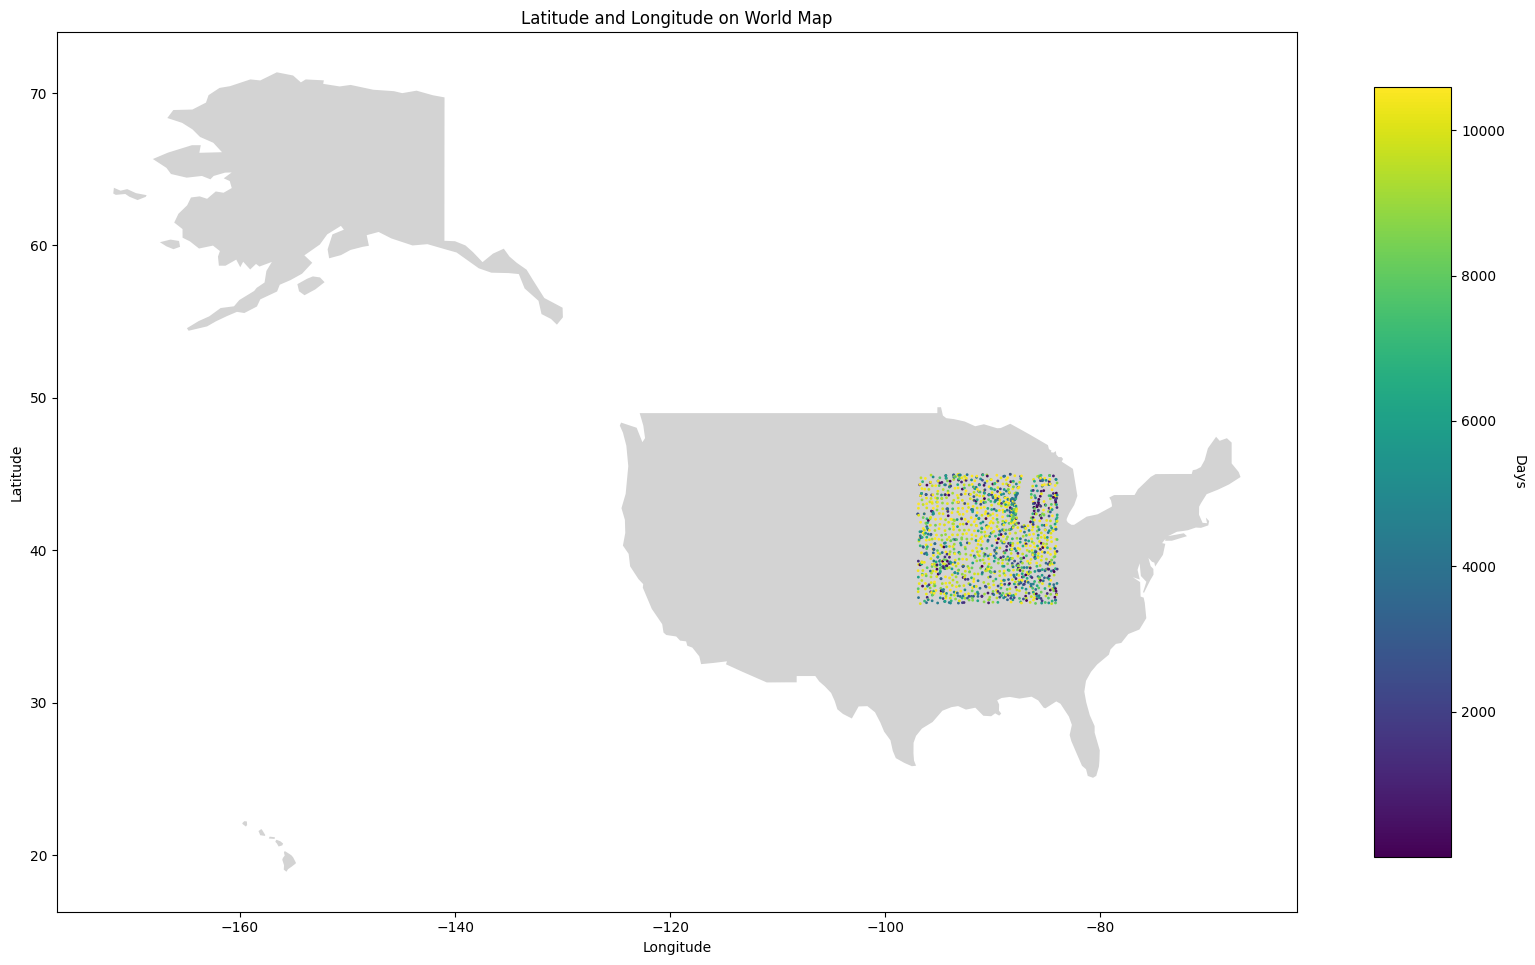

In [38]:
# plot of geographical position
coordinates = data_clean.groupby(['Longitude','Latitude']).size().reset_index(name="days")
min = coordinates['days'].min()
max = coordinates['days'].max()
norm = plt.Normalize(min, max)
colors = plt.cm.viridis(norm(coordinates['days']))

# Load a world map using GeoPandas
url = 'https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson'
world = gpd.read_file(url)
#print(world.columns)
usa = world[(world['admin'] == 'United States of America')]
# Plot the world map
fig, ax = plt.subplots(figsize=(20, 20))
usa.plot(ax=ax, color='lightgrey')

# Plot the points on the map
plt.scatter(coordinates['Longitude'], coordinates['Latitude'], color=colors, marker='o', s=1)
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Days", rotation=270, labelpad=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Latitude and Longitude on World Map")
plt.show()

In [39]:
d_aggregate_month = data_clean[['MONTH', 'TMIN', 'TMAX','PRCP']].groupby('MONTH').mean().reset_index()

In [57]:
d_export = d_aggregate_month
d_export.to_csv("typical_weather_for_months.csv", index=False)
d_export.head(20)

,MONTH,TMIN_month,TMAX_month,PRCP_month
0,1,-8.615716,1.117959,16.139716
1,2,-7.253984,3.252431,17.453910
2,3,-1.682062,9.796652,22.495730
3,4,3.978044,16.520252,33.845054
4,5,10.186761,22.368373,39.092626
5,6,15.655915,27.455557,40.497511
6,7,17.801225,29.465188,33.338497
7,8,16.696339,28.638396,31.909691
8,9,12.223576,25.158060,29.092770
9,10,5.755787,18.049663,26.751608


In [40]:
#lock for exceptional days
d_aggregate_month.rename(columns={'TMIN': 'TMIN_month'}, inplace=True)
d_aggregate_month.rename(columns={'TMAX': 'TMAX_month'}, inplace=True)
d_aggregate_month.rename(columns={'PRCP': 'PRCP_month'}, inplace=True)
d_variation = pd.merge(data_clean, d_aggregate_month, on='MONTH', how='inner')
d_variation['TMIN_dif'] = d_variation['TMIN']-d_variation['TMIN_month']
d_variation['TMAX_dif'] = d_variation['TMAX']-d_variation['TMAX_month']
d_variation['PRCP_dif'] = d_variation['PRCP']-d_variation['PRCP_month']
d_variation.head(10)

,ID,DATE,TMAX,TMIN,PRCP,Latitude,Longitude,Elevation,YEAR,MONTH,TMIN_month,TMAX_month,PRCP_month,TMIN_dif,TMAX_dif,PRCP_dif
0,USC00201675,2012-09-26,20.0,10.0,0.0,41.9622,-84.9925,299.9,2012,9,12.223576,25.158060,29.092770,-2.223576,-5.158060,-29.092770
1,USC00230657,2007-05-10,26.7,13.9,3.0,37.0539,-93.5756,399.3,2007,5,10.186761,22.368373,39.092626,3.713239,4.331627,-36.092626
2,USC00236045,2008-04-16,15.0,0.6,0.0,36.5869,-89.5325,92.0,2008,4,3.978044,16.520252,33.845054,-3.378044,-1.520252,-33.845054
3,USC00148563,2017-02-20,16.1,6.1,94.0,39.2142,-96.3700,355.4,2017,2,-7.253984,3.252431,17.453910,13.353984,12.847569,76.546090
4,USW00013809,2004-07-29,26.7,16.1,0.0,38.7606,-87.5989,130.1,2004,7,17.801225,29.465188,33.338497,-1.701225,-2.765188,-33.338497
5,USC00148964,1995-04-30,12.8,9.4,89.0,37.2886,-96.9408,375.8,1995,4,3.978044,16.520252,33.845054,5.421956,-3.720252,55.154946
6,USC00235708,2018-07-18,29.4,17.8,0.0,39.6350,-91.7233,225.9,2018,7,17.801225,29.465188,33.338497,-0.001225,-0.065188,-33.338497
7,USC00144559,2000-01-20,8.3,-10.6,0.0,38.9583,-95.2514,320.0,2000,1,-8.615716,1.117959,16.139716,-1.984284,7.182041,-16.139716
8,USC00120200,2016-04-10,0.6,-3.9,56.0,41.6639,-85.0183,310.9,2016,4,3.978044,16.520252,33.845054,-7.878044,-15.920252,22.154946
9,USC00238583,2006-02-12,2.2,-10.0,0.0,36.9858,-92.2058,342.3,2006,2,-7.253984,3.252431,17.453910,-2.746016,-1.052431,-17.453910


In [41]:
quartiles = d_variation[['TMIN_dif', 'TMAX_dif', 'PRCP_dif']].quantile([0.25,0.5,0.75])
print(quartiles)

      TMIN_dif  TMAX_dif   PRCP_dif
0.25 -3.555787 -4.128568 -31.909691
0.50  0.315716  0.047569 -21.485045
0.75  3.876424  4.161604 -16.139716


In [45]:
d_exceptional = d_variation.copy()
d_exceptional['colder'] = np.where(d_exceptional['TMIN_dif'] < quartiles.loc[0.25,'TMIN_dif'], 1, 0)
d_exceptional['hotter'] = np.where(d_exceptional['TMAX_dif'] > quartiles.loc[0.75,'TMAX_dif'], 1, 0)
d_exceptional['drier'] = np.where(d_exceptional['PRCP_dif'] < quartiles.loc[0.25,'PRCP_dif'] , 1, 0)
d_exceptional['wetter'] = np.where(d_exceptional['PRCP_dif'] > quartiles.loc[0.75,'PRCP_dif'], 1, 0)
d_exceptional = d_exceptional[['YEAR','MONTH','colder','hotter','drier','wetter']]

In [47]:
d_exceptional_grouped = d_exceptional.groupby(['YEAR','MONTH']).mean().reset_index()
d_exceptional_grouped['LABEL'] = np.where(d_exceptional_grouped['MONTH'] == 1, d_exceptional_grouped['YEAR'].astype(str), "")
d_exceptional_grouped['DATE'] = d_exceptional_grouped['MONTH'].astype(str) + "_" + d_exceptional_grouped['YEAR'].astype(str)
d_exceptional_grouped = d_exceptional_grouped[(d_exceptional_grouped['colder']<=0.99) & (d_exceptional_grouped['hotter']<=0.99) 
                                                & (d_exceptional_grouped['drier']<=0.99) & (d_exceptional_grouped['wetter']<=0.99)]
d_exceptional_grouped.head()

,YEAR,MONTH,colder,hotter,drier,wetter,LABEL,DATE
0,1992,1,0.176533,0.371571,0.000000,0.256202,1992,1_1992
1,1992,2,0.072567,0.400601,0.000000,0.237913,,2_1992
2,1992,3,0.238459,0.329808,0.000000,0.296457,,3_1992
3,1992,4,0.273102,0.273853,0.615064,0.256096,,4_1992
4,1992,5,0.325291,0.308441,0.793783,0.152572,,5_1992


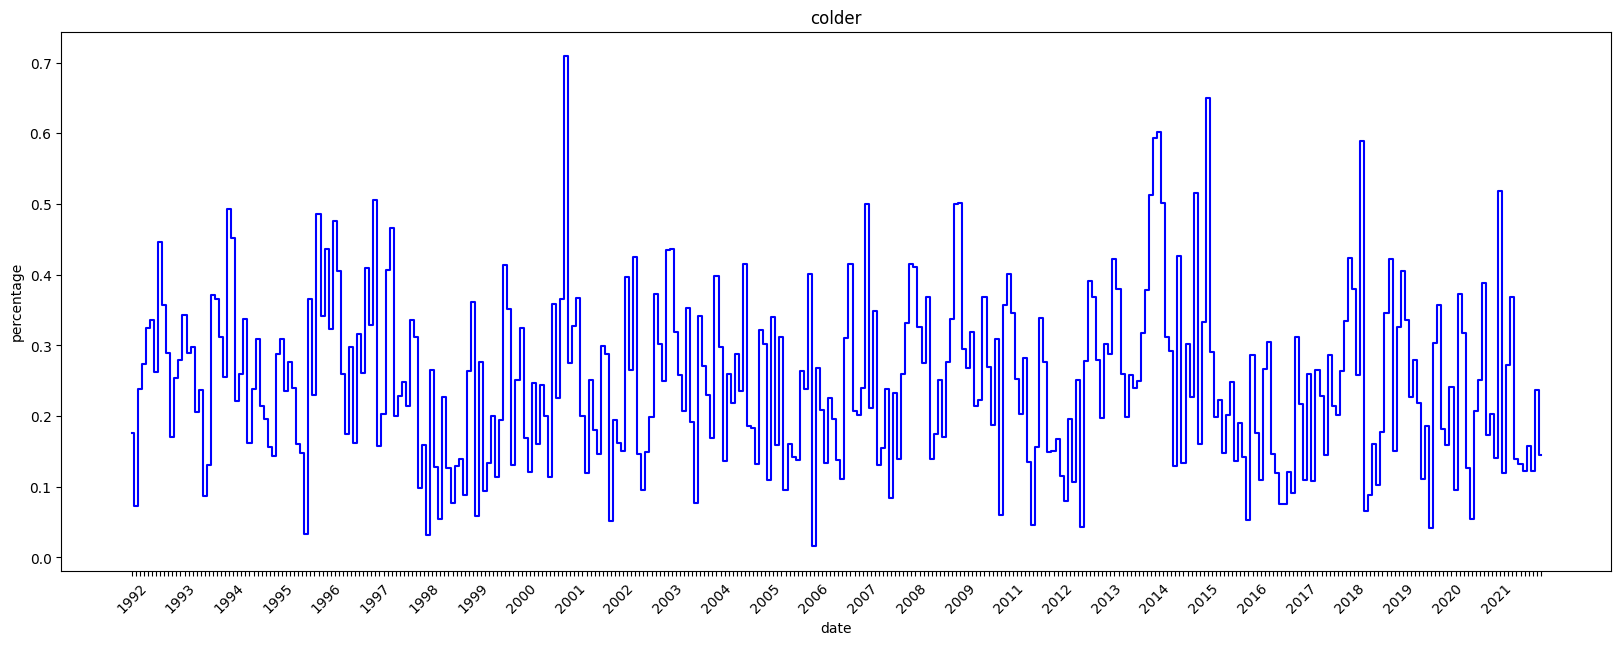

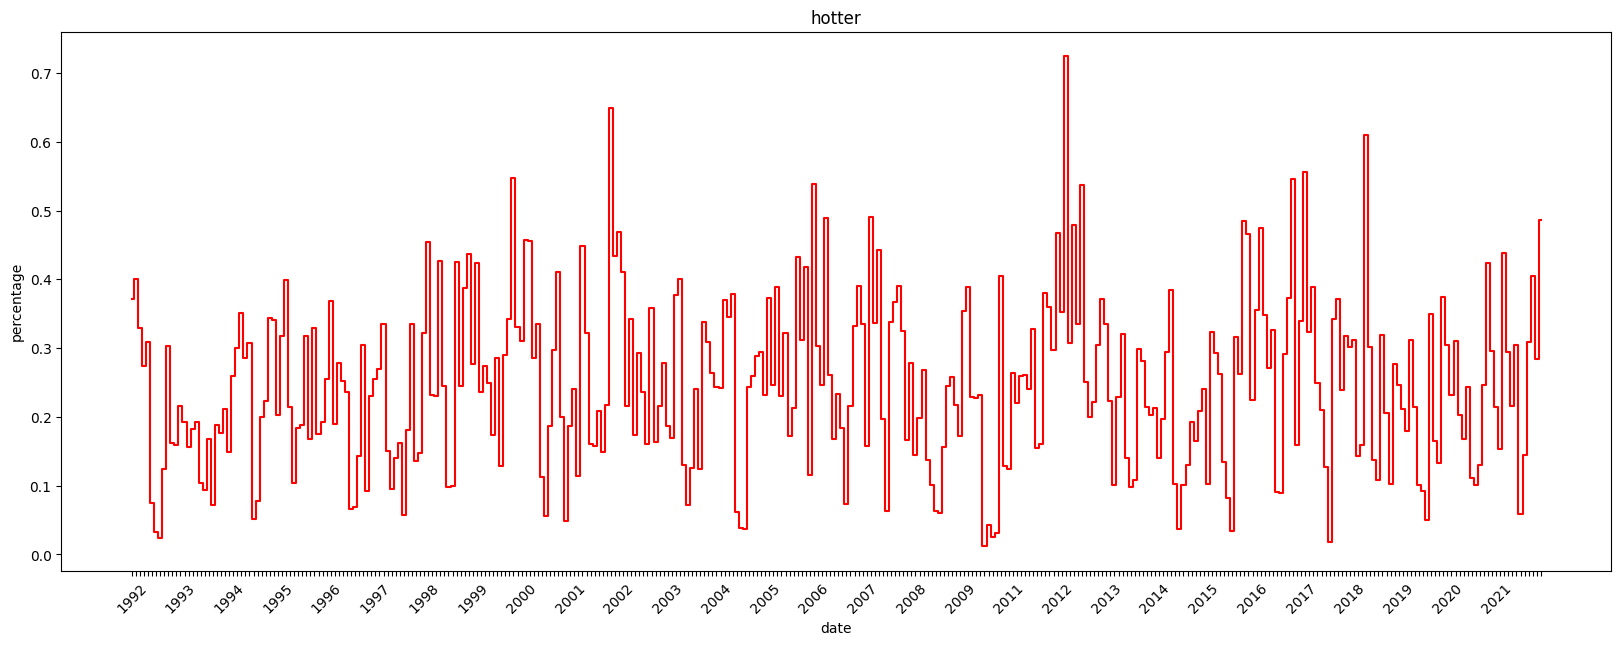

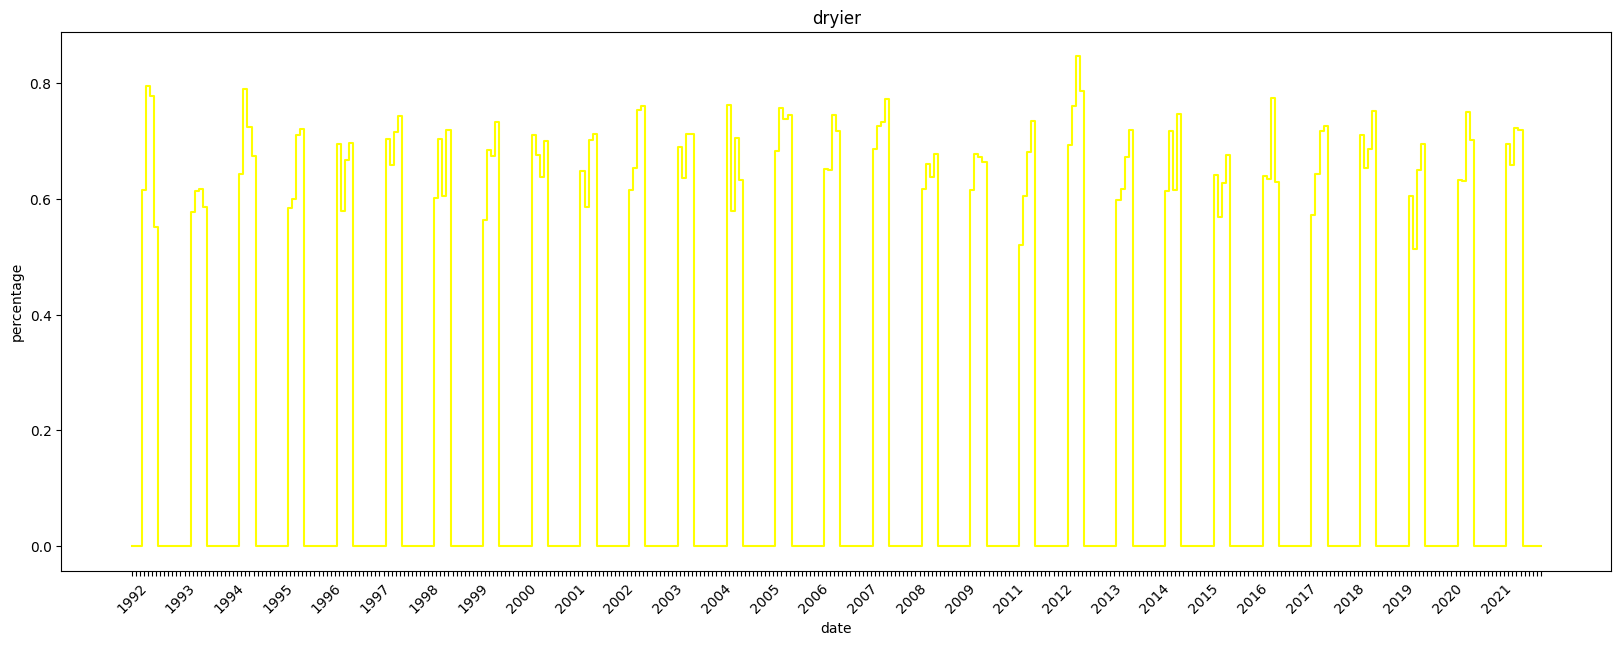

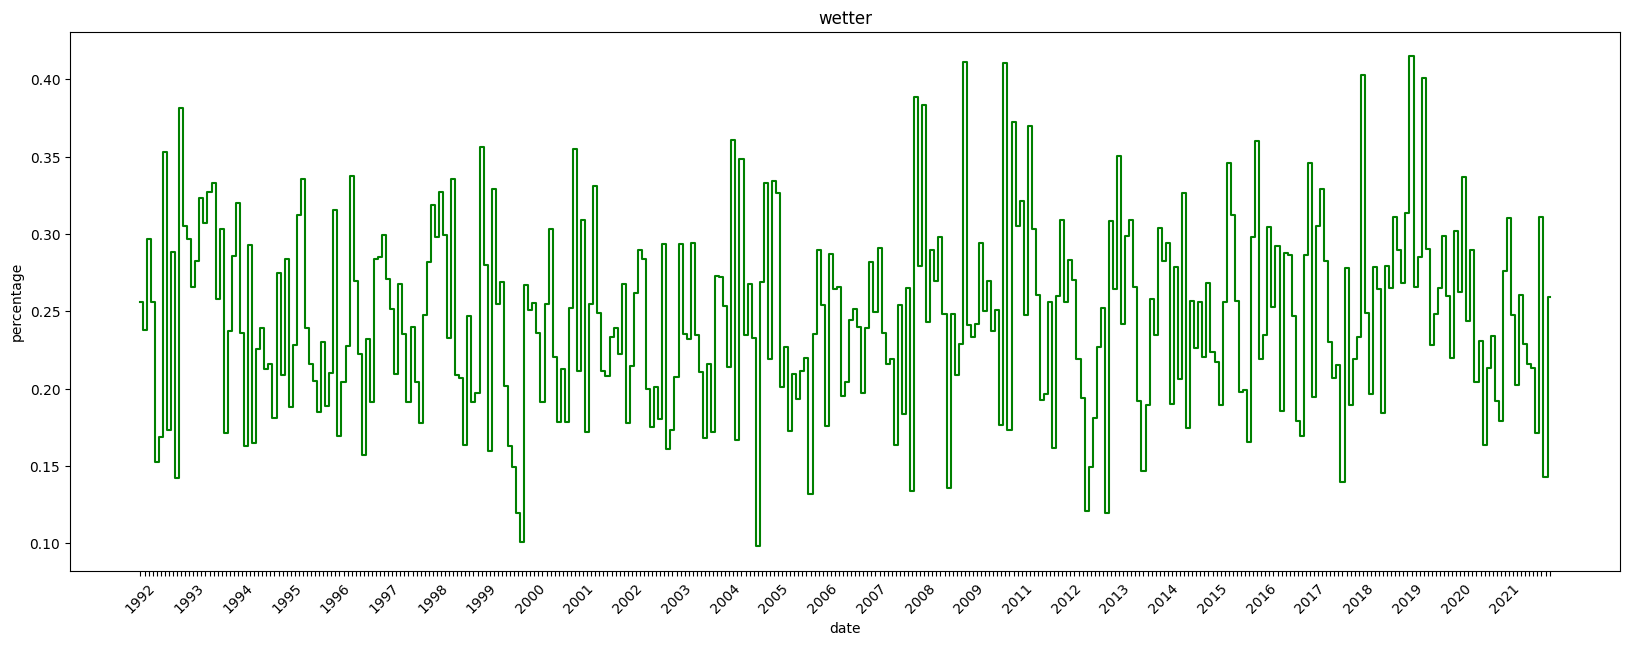

In [48]:
plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["colder"], where='mid', color='blue')
plt.xlabel("date")
plt.ylabel("percentage")
plt.title("colder")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["hotter"], where='mid', color='red')
plt.xlabel("date")
plt.ylabel("percentage")
plt.title("hotter")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["drier"], where='mid', color='yellow')
plt.xlabel("date")
plt.ylabel("percentage")
plt.title("dryier")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 7))
plt.step(d_exceptional_grouped["DATE"], d_exceptional_grouped["wetter"], where='mid', color="green")
plt.xlabel("date")
plt.ylabel("percentage")
plt.title("wetter")
plt.xticks(ticks=range(len(d_exceptional_grouped['DATE'])), labels=d_exceptional_grouped['LABEL'], rotation=45)
plt.show()


In [49]:

quartiles2 = d_exceptional_grouped[['hotter', 'colder', 'wetter','drier']].quantile(0.90)
print(quartiles2)

hotter    0.401725
colder    0.405280
wetter    0.320369
drier     0.712144
Name: 0.9, dtype: float64


In [51]:
d_exceptional2 = d_exceptional_grouped.copy()
d_exceptional2['colder'] = np.where(d_exceptional_grouped['colder'] > quartiles2['colder'], 1, 0)
d_exceptional2['hotter'] = np.where(d_exceptional_grouped['hotter'] > quartiles2['hotter'], 1, 0)
d_exceptional2['drier'] = np.where(d_exceptional_grouped['drier'] > quartiles2['drier'] , 1, 0)
d_exceptional2['wetter'] = np.where(d_exceptional_grouped['wetter'] > quartiles2['wetter'], 1, 0)

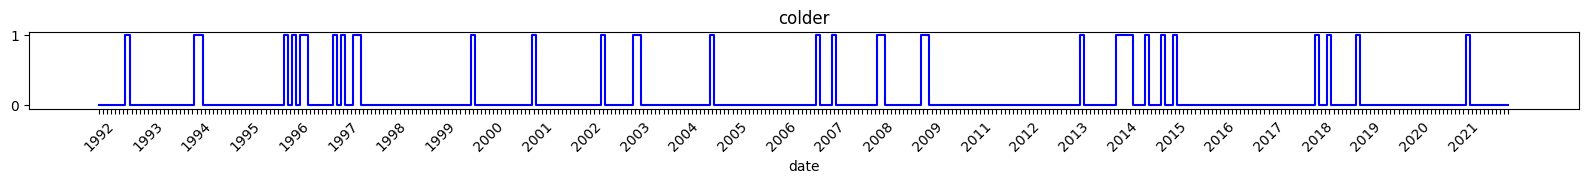

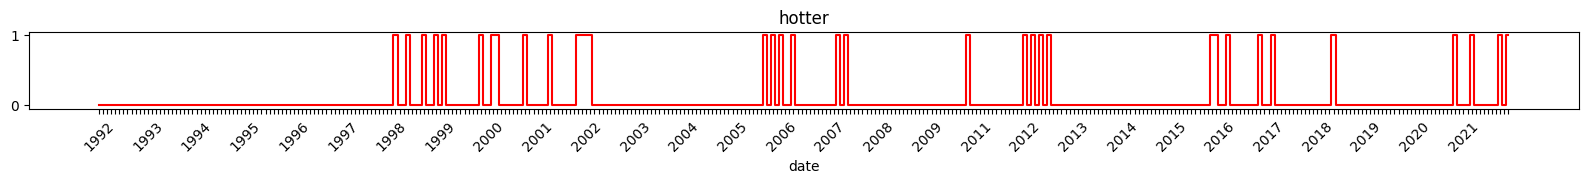

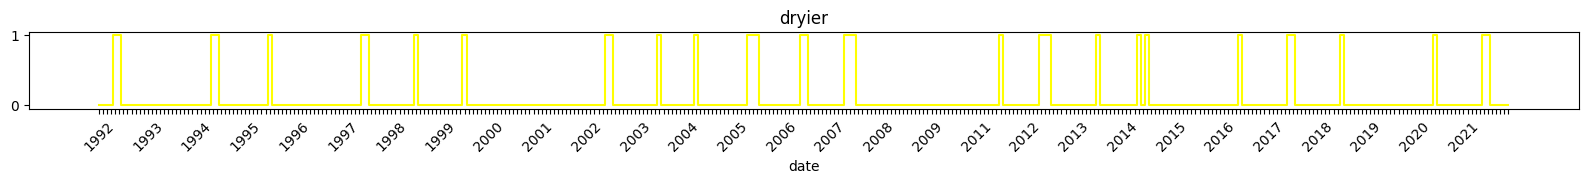

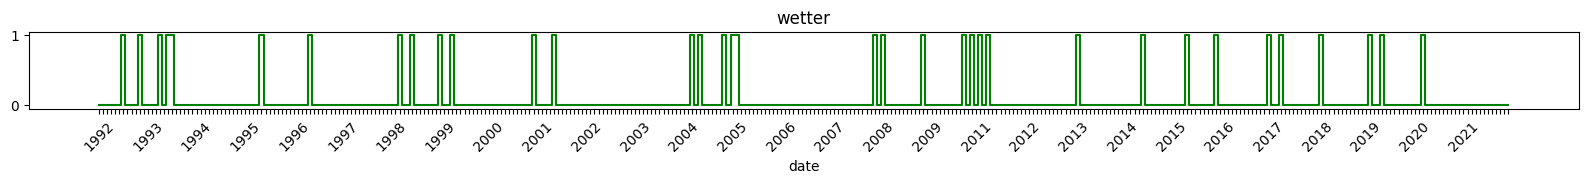

In [ ]:
plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["colder"], where='mid', color='blue')
plt.xlabel("date")
plt.title("colder")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["hotter"], where='mid', color='red')
plt.xlabel("date")
plt.title("hotter")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["drier"], where='mid', color='yellow')
plt.xlabel("date")
plt.title("drier")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()

plt.figure(figsize=(20, 1))
plt.step(d_exceptional2["DATE"], d_exceptional2["wetter"], where='mid', color='green')
plt.xlabel("date")
plt.title("wetter")
plt.xticks(ticks=range(len(d_exceptional2['DATE'])), labels=d_exceptional2['LABEL'], rotation=45)
plt.show()


In [53]:
d_export = d_exceptional_grouped[["YEAR","MONTH","colder","hotter","wetter","drier"]]
d_export.to_csv("weather_exceptional_months_perc.csv", index=False)
d_export.head(20)

,YEAR,MONTH,colder,hotter,wetter,drier
0,1992,1,0.176533,0.371571,0.256202,0.000000
1,1992,2,0.072567,0.400601,0.237913,0.000000
2,1992,3,0.238459,0.329808,0.296457,0.000000
3,1992,4,0.273102,0.273853,0.256096,0.615064
4,1992,5,0.325291,0.308441,0.152572,0.793783
5,1992,6,0.336126,0.075454,0.168796,0.777368
6,1992,7,0.262434,0.032995,0.353211,0.550620
7,1992,8,0.446684,0.024063,0.172916,0.000000
8,1992,9,0.357415,0.124880,0.288312,0.000000
9,1992,10,0.288879,0.303285,0.142160,0.000000


In [54]:
d_export = d_exceptional2[["YEAR","MONTH","colder","hotter","wetter","drier"]]
d_export.to_csv("weather_exceptional_months_bin.csv", index=False)
d_export.head(20)


,YEAR,MONTH,colder,hotter,wetter,drier
0,1992,1,0,0,0,0
1,1992,2,0,0,0,0
2,1992,3,0,0,0,0
3,1992,4,0,0,0,0
4,1992,5,0,0,0,1
5,1992,6,0,0,0,1
6,1992,7,0,0,1,0
7,1992,8,1,0,0,0
8,1992,9,0,0,0,0
9,1992,10,0,0,0,0
